In [ ]:
import os
import sys
root_path = os.path.join(os.path.expanduser('~'), 'bnelearn')
if root_path not in sys.path:
    sys.path.append(root_path)

import torch

import pandas as pd
from plotnine import *

from bnelearn.mechanism import LLLLGGAuction
from bnelearn.sampler import LLLLGGSampler
from bnelearn.environment import AuctionEnvironment
from bnelearn.strategy import TruthfulStrategy
from bnelearn.util.metrics import ex_interim_util_loss
from bnelearn.bidder import Bidder


device = 'cuda:3'
torch.cuda.set_device(3)

In [ ]:
batch_size = 2**10

mechanism = LLLLGGAuction(rule = 'vcg', core_solver = 'mpc', cuda = True)
sampler = LLLLGGSampler(default_batch_size = batch_size, default_device= device)
agents = [Bidder(TruthfulStrategy(), i, batch_size, 2, 2, 2) for i in range(6)]
env = AuctionEnvironment(mechanism, agents, sampler, batch_size)

In [ ]:
## Collect ex-interim loss distribution data for local bidder for different
## opponent_batch and grid_sizes

df = pd.DataFrame()
for log_grid_size in range(7,11):
    for log_opp_batch_size in range(7,15):
        print(log_grid_size, log_opp_batch_size)
        try:
            i = 0
            obs_i = env._observations[:,i,:]
            losses, br = ex_interim_util_loss(env, i, obs_i, 2**log_grid_size, 2**log_opp_batch_size, True)

            df_facet = pd.DataFrame({
                    'player': i,
                    'log_grid_size': log_grid_size,
                    'log_opp_batch_size': log_opp_batch_size,
                    'loss': losses.cpu()
                })
            df = df.append(df_facet)
        except e:
            print('failed.')

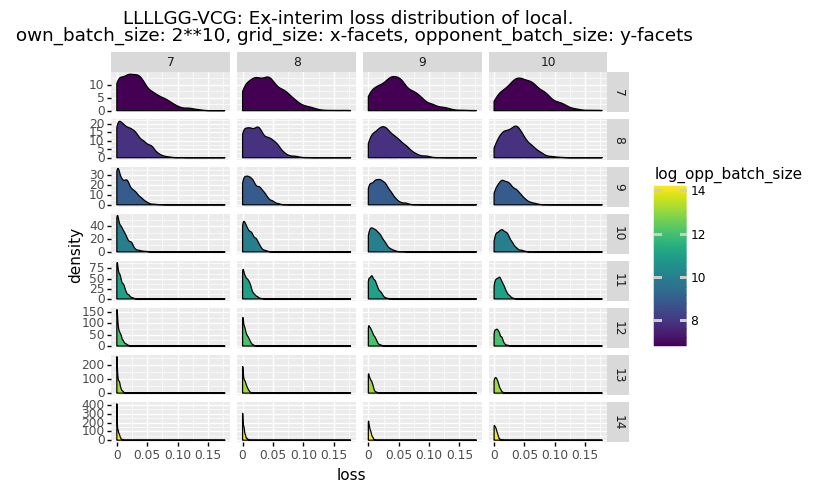

<ggplot: (8745388102382)>

In [6]:
# Plot the distributions

ggplot(df, aes('loss', fill = 'log_opp_batch_size')) + \
    stat_density() + \
    facet_grid('log_opp_batch_size ~ log_grid_size', scales='free_y') + \
    labs(title = "LLLLGG-VCG: Ex-interim loss distribution of local. \n own_batch_size: 2**10, grid_size: x-facets, opponent_batch_size: y-facets")